#### UNet-based water detection on scene level using openEO

In [1]:
This notebook aims to demonstrate how to do model inference using open. This can be done using a user-defined function (https://open-eo.github.io/openeo-python-client/udf.html).

Below two U-Nets for water detection can be applied, 1) using Sentinel-2 bands B2, B3, B4 and B8, and 2) using Sentinel-2 bands B2, B3, B4, B8, B11 and B12 as well as Sentinel-1 bands VV and VH.

The final section illustrates how to locally debug when developping your UDF.

SyntaxError: invalid syntax (3583758322.py, line 1)

In [1]:
import os
import json
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import shape, box
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import numpy as np
import openeo
# import contextily as cx

In [2]:
def make_plotting_array(dataarray, vmin=0, vmax=0.25, scale=1e4):
    """ scale xr array to 0-1 using the defined lower and upper limits and scale, for plotting with matplotlib """
    arr = dataarray.copy()
    arr = arr.where(arr <= scale)
    arr /= scale
    arr = arr.where(arr < vmax, vmax)
    arr = arr.where(arr > vmin, vmin)
    return (arr - vmin) / (vmax - vmin)

In [15]:
def download_job_result(job, dir_output, fformat="nc"):
    """ download job result to specifed output directory, file name is taken from job title """
    if job.status() != "finished":
        print("Job status '{}', aborting.".format(job.status()))
        return None
    # Get the results
    results = job.get_results()
    # Loop over the resulting assets and download
    for i_a, asset in enumerate(results.get_assets()):
        asset_suffix = "-{}".format(i_a) if i_a > 0 else ""
        asset_targetname = os.path.join(dir_output, "{}{}.{}".format(job.describe_job()["title"], asset_suffix, fformat))
        if os.path.exists(asset_targetname):
            asset_targetname = asset_targetname.replace(".{}".format(fformat), "-new.{}".format(fformat))
        print("{} - Downloading {}".format(datetime.datetime.now(), asset_targetname))
        ts = datetime.datetime.now()
        asset.download(asset_targetname)
        te = datetime.datetime.now()
        print("\tDownload finished after {} sec.".format(round((te-ts).total_seconds())))
    return asset_targetname

In [4]:
# from unet_s1s2_timerange import scale_sentinel

In [13]:
# Connect to openeo backend
connection = openeo.connect("openeo.vito.be",default_timeout=1000)

In [14]:
connection.authenticate_oidc()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [21]:
# Define the parameters: AOI bounds, year, month
aoi_name = "EastFlandersSmall" #"EastFlanders"
year = 2022
month = 5

aoi_bounds = [506800, 5640100, 553400, 5650900] #[466800, 5616100, 603400, 5693900]
crs_epsg = 32631

spatial_extent = dict(zip(["west", "south", "east", "north"], aoi_bounds)) # box(*aoi_bounds).buffer(-30000).bounds)
spatial_extent["crs"] = crs_epsg

startdate = "{}-{:02d}-{:02d}".format(year, month, 1)
enddate = "{}-{:02d}-{:02d}".format(year, month+1, 1)

## Water detection based on Sentinel-2 only

We will run our UDF on the data cube using the apply_neighborhood() process. We can pass additional arguments for the UDF, like the model path, using the context argument. The size parameter defines the core size of the neighborhoods that are stitched back together, the overlap parameter defines the padding added at each size. So your U-Net should take patches of size+2*overlap as input.

In [22]:
# Model path (should be stored on MEP)
path_model = "D:/GEOINF/vgg16_100_8/model_20231115150333_bestvalacc.pth"

In [23]:
# Define bands in alignment with model inputs
bands_s2 = ["B04", "B03", "B02"]

In [24]:
# Load datacube
input_data = connection.load_collection(
    "TERRASCOPE_S2_TOC_V2",
    temporal_extent=[startdate, enddate],
    spatial_extent=spatial_extent,
    bands=bands_s2,
)

In [25]:
# Apply model on openeo server
segmentationband = input_data.apply_neighborhood(
    lambda data: data.run_udf(udf=Path('unet_si_timerange (1).py').read_text(),
                              runtime='Python',
                              context={"path_model": path_model}),
    size=[
        {'dimension': 'x', 'value': 256, 'unit': 'px'},
        {'dimension': 'y', 'value': 256, 'unit': 'px'},
        {'dimension': 't', 'value': 'P1D'} # this will map the UDF on every scene in the collection (https://en.wikipedia.org/wiki/ISO_8601#Durations)
    ],
    overlap=[
        {'dimension': 'x', 'value': 0, 'unit': 'px'},
        {'dimension': 'y', 'value': 0, 'unit': 'px'}
    ]
)

segmentationband = segmentationband.rename_labels(dimension="bands", target=["prediction"] + [""] * (len(bands_s2)-1))
segmentationband = segmentationband.filter_bands(["prediction"])

Default job resources are 2 executor cores with 2G memory en 3G memory overhead, but these need to be increased for larger AOIs. See https://docs.openeo.cloud/federation/#customizing-batch-job-resources-on-terrascope for more info.

In [ ]:
# Submit job

job_options = { # trial-error based, I'm currently using 2G/6G for the smaller AOIs and 8G/8G for the larger AOIs
    "executor-memory": "3G",
    "executor-memoryOverhead": "8G",
    "executor-cores": "2"
}

job = segmentationband.create_job(out_format="NetCDF", title="UNet_S2_{}_{}_{}".format(aoi_name, startdate, enddate), job_options=job_options)
job.start_job()

In [30]:
# Follow up job status
connection.list_jobs()

OpenEoApiError: [401] AuthenticationRequired: Unauthorized. (ref: r-2402216dd9124b49babef1dfa1025d05)

In [13]:
job_id = "j-2401303443f54504af76d34ba50f842e"
j = connection.job(job_id)
j.logs()

[{'id': '[1706574609851, 84673748]',
  'time': '2024-01-30T00:30:09.851Z',
  'level': 'info',
  'message': "EJR creating job_id='j-2401303443f54504af76d34ba50f842e' created='2024-01-30T00:30:09Z'"},
 {'id': '[1706574609851, 84674191]',
  'time': '2024-01-30T00:30:09.851Z',
  'level': 'debug',
  'message': 'EJR Request `POST /jobs`: start 2024-01-30 00:30:09.851326'},
 {'id': '[1706574609851, 84674599]',
  'time': '2024-01-30T00:30:09.851Z',
  'level': 'debug',
  'message': "Doing EJR request `POST https://jobregistry.openeo.vito.be/jobs` headers.keys()=dict_keys(['Authorization'])"},
 {'id': '[1706574609952, 84675063]',
  'time': '2024-01-30T00:30:09.952Z',
  'level': 'debug',
  'message': 'EJR response on `POST /jobs`: 201'},
 {'id': '[1706574609953, 84675453]',
  'time': '2024-01-30T00:30:09.953Z',
  'level': 'debug',
  'message': 'EJR Request `POST /jobs`: end 2024-01-30 00:30:09.953032, elapsed 0:00:00.101706'},
 {'id': '[1706574611553, 83604694]',
  'time': '2024-01-30T00:30:11.553Z',
  'level': 'info',
  'message': "EJR get job data job_id='j-2401303443f54504af76d34ba50f842e'"},
 {'id': '[1706574611553, 83605110]',
  'time': '2024-01-30T00:30:11.553Z',
  'level': 'debug',
  'message': 'Doing search with query {"query": {"bool": {"filter": [{"term": {"backend_id": "mep-prod"}}, {"term": {"job_id": "j-2401303443f54504af76d34ba50f842e"}}]}}, "_source": ["status", "*", "created", "job_id", "updated", "user_id"]}'},
 {'id': '[1706574611553, 83605725]',
  'time': '2024-01-30T00:30:11.553Z',
  'level': 'debug',
  'message': 'EJR Request `POST /jobs/search`: start 2024-01-30 00:30:11.553572'},
 {'id': '[1706574611553, 83606140]',
  'time': '2024-01-30T00:30:11.553Z',
  'level': 'debug',
  'message': "Doing EJR request `POST https://jobregistry.openeo.vito.be/jobs/search` headers.keys()=dict_keys(['Authorization'])"},
 {'id': '[1706574611635, 83606612]',
  'time': '2024-01-30T00:30:11.635Z',
  'level': 'debug',
  'message': 'EJR response on `POST /jobs/search`: 200'},
 {'id': '[1706574611635, 83607009]',
  'time': '2024-01-30T00:30:11.635Z',
  'level': 'debug',
  'message': 'EJR Request `POST /jobs/search`: end 2024-01-30 00:30:11.635499, elapsed 0:00:00.081927'},
 {'id': '[1706574611777, 83621870]',
  'time': '2024-01-30T00:30:11.777Z',
  'level': 'info',
  'message': "Starting job 'j-2401303443f54504af76d34ba50f842e' from user User('bdcc32ca20a6ae9066f153be2abae36a88bbe8996154c0273396b4ec83fa6311@egi.eu', {'oidc_userinfo': {'sub': 'bdcc32ca20a6ae9066f153be2abae36a88bbe8996154c0273396b4ec83fa6311@egi.eu', 'voperson_verified_email': ['mingshi.li@kuleuven.be'], 'email_verified': True, 'eduperson_scoped_affiliation': ['faculty@kuleuven.be', 'employee@kuleuven.be', 'bap@kuleuven.be', 'member@kuleuven.be'], 'eduperson_assurance': ['https://refeds.org/assurance/IAP/low', 'https://aai.egi.eu/LoA#Substantial'], 'eduperson_entitlement': ['urn:mace:egi.eu:group:vo.openeo.cloud:role=member#aai.egi.eu', 'urn:mace:egi.eu:group:vo.openeo.cloud:role=vm_operator#aai.egi.eu', 'urn:mace:egi.eu:res:gocdb#aai.egi.eu', 'urn:mace:egi.eu:res:rcauth#aai.egi.eu'], 'email': 'mingshi.li@kuleuven.be'}}) (proxy user 'limingshi1994')"},
 {'id': '[1706574611823, 83623790]',
  'time': '2024-01-30T00:30:11.823Z',
  'level': 'info',
  'message': "EJR update job_id='j-2401303443f54504af76d34ba50f842e' data={'proxy_user': 'limingshi1994'}"},
 {'id': '[1706574611823, 83624236]',
  'time': '2024-01-30T00:30:11.823Z',
  'level': 'debug',
  'message': 'EJR Request `PATCH /jobs/j-2401303443f54504af76d34ba50f842e`: start 2024-01-30 00:30:11.823556'},
 {'id': '[1706574611823, 83624680]',
  'time': '2024-01-30T00:30:11.823Z',
  'level': 'debug',
  'message': "Doing EJR request `PATCH https://jobregistry.openeo.vito.be/jobs/j-2401303443f54504af76d34ba50f842e` headers.keys()=dict_keys(['Authorization'])"},
 {'id': '[1706574611955, 83625180]',
  'time': '2024-01-30T00:30:11.955Z',
  'level': 'debug',
  'message': 'EJR response on `PATCH /jobs/j-2401303443f54504af76d34ba50f84

In [ ]:
# Download result based on job id
job_id = "j-47673edec3104751a2764aa76d257f42"
path_result = download_job_result(connection.job(job_id), os.getcwd(), fformat="nc")
print(path_result)

In [ ]:
# Investigate result
ds = xr.open_dataset(path_result)
ds

In [ ]:
# random selection of results
nc = 4
fig, ax = plt.subplots(nc, nc, figsize=(3*nc, 3*nc))
for subax in ax.ravel():
    t = np.random.choice(ds.t.values)
    subax.imshow(ds["prediction"].sel(t=t).values, vmin=0, vmax=1)
    subax.set_title(pd.to_datetime(t).strftime("%Y-%m-%d"))

## Local UDF debugging

For local debugging, these are the steps to follow:
- Download the dataset
- Save a subset that is the same size as the neighborhood
- Run execute_local_udf (make sure path to UDF is defined, and is accessible)
- Inspect the result

In [13]:
path_testinput = 'unet-s1-s2_test-input.nc'
path_testsubset = "unet-s1-s2_test-subset.nc"

In [ ]:
# Download test dataset
input_data.download(path_testinput, format='NetCDF')

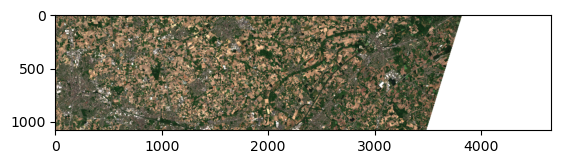

<xarray.Dataset>
Dimensions:  (t: 11, x: 4660, y: 1080)
Coordinates:
  * t        (t) datetime64[ns] 2022-05-03 2022-05-05 ... 2022-05-28 2022-05-30
  * x        (x) float64 5.068e+05 5.068e+05 5.068e+05 ... 5.534e+05 5.534e+05
  * y        (y) float64 5.651e+06 5.651e+06 5.651e+06 ... 5.64e+06 5.64e+06
Data variables:
    crs      |S1 ...
    B04      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B02      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [14]:
# Inspect test data
ds_test = xr.open_dataset(path_testinput)

fig, ax = plt.subplots()
ax.imshow(make_plotting_array(ds_test[["B04", "B03", "B02"]].sel(t=ds_test.t.values[2]).to_array().transpose("y", "x", "variable")))
plt.show()

ds_test

In [15]:
# Save test subset for local debugging
ds_subset = ds_test.sel(x=ds_test.x.values[400:656], y=ds_test.y.values[400:656]) # select ranges based on visual inspection
if os.path.exists(path_testsubset):
    os.remove(path_testsubset)
ds_subset.to_netcdf(path_testsubset)

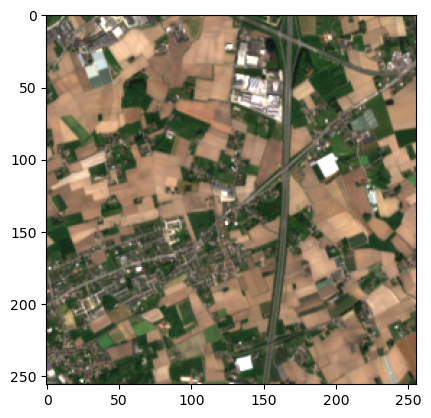

<xarray.Dataset>
Dimensions:  (t: 11, x: 256, y: 256)
Coordinates:
  * t        (t) datetime64[ns] 2022-05-03 2022-05-05 ... 2022-05-28 2022-05-30
  * x        (x) float64 5.108e+05 5.108e+05 5.108e+05 ... 5.133e+05 5.134e+05
  * y        (y) float64 5.647e+06 5.647e+06 5.647e+06 ... 5.644e+06 5.644e+06
Data variables:
    crs      |S1 ...
    B04      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B02      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [16]:
# Inspect subset
ds_subset = xr.open_dataset(path_testsubset)

fig, ax = plt.subplots()
ax.imshow(make_plotting_array(ds_subset[["B04", "B03", "B02"]].sel(t=ds_subset.t.values[2]).to_array().transpose("y", "x", "variable")))
plt.show()

ds_subset

In [17]:
# Apply model locally
from openeo.udf.run_code import execute_local_udf

udf = Path("unet_si_timerange (1).py").read_text()
ds_res = execute_local_udf(udf, path_testsubset, fmt="netcdf")

INFO:openeo.udf.run_code:Found datacube mapping UDF `apply_datacube` <function apply_datacube at 0x000002A928863F70>
INFO:openeo.udf.debug.user:path_model set to default
INFO:openeo.udf.debug.user:cubearray


(3, 256, 256)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\limin/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

INFO:openeo.udf.debug.user:result
INFO:openeo.udf.debug.user:result_xarray


In [18]:
# Investigate results
ds_test = xr.open_dataset(path_testsubset)

res_array = ds_res.get_datacube_list()[0].get_array()
print(res_array.sizes)
print(type(res_array))

Frozen({'bands': 1, 'y': 256, 'x': 256})
<class 'xarray.core.dataarray.DataArray'>


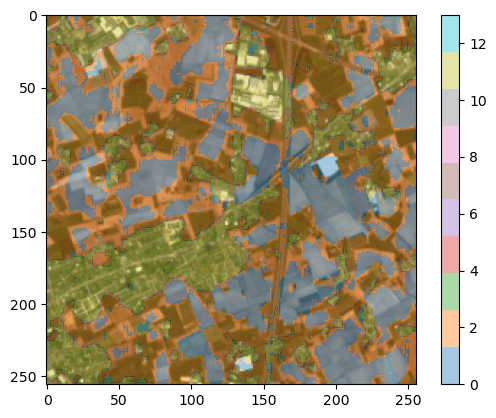

In [19]:
# Plotting the DataArray as a colormap
data_to_plot = res_array[0]
plt.imshow(make_plotting_array(ds_subset[["B04", "B03", "B02"]].sel(t=ds_subset.t.values[2]).to_array().transpose("y", "x", "variable")))
plt.imshow(data_to_plot, cmap='tab10',alpha=0.4)  # You can choose different colormaps like 'jet', 'gray', etc.
plt.colorbar()  # To show the color scale
plt.show()